In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import Model
from dropout import *

from data import generate_data
from train import train_main_model, train_deup
from utils import inv_sigmoid, evaluate_and_plot, eval_error

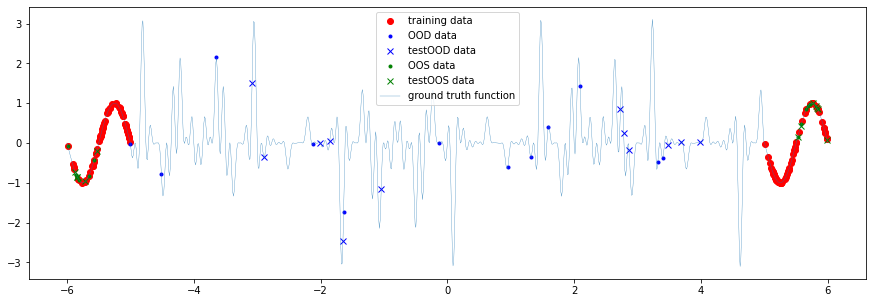

In [38]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 24, 24, seed=7, plot=True, device='cuda',
                                                                     distance=10.5, shuffle=True, offset=-5.5)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

## Training a noise generator

In [ ]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(-2.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=MultiplicativeGaussian, mu=None, logsigma=logsigma,
                              noise_generator=noise_generator).cuda()
print([x[0] for x in model.named_parameters()])

## Training a single scalar

In [39]:
n_hidden = 256
hidden_layers = 6
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(-2.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=RegularDropout, logit=nn.Parameter(torch.tensor(-6.).cuda())).cuda()
print([x[0] for x in model.named_parameters()])

{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
{'logit': Parameter containing:
tensor(-6., device='cuda:0', requires_grad=True)}
<class 'torch.nn.parameter.Parameter'>
registering
['model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.dropout1.logit', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'mo

In [40]:
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)

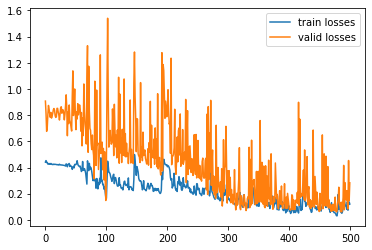

In [41]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

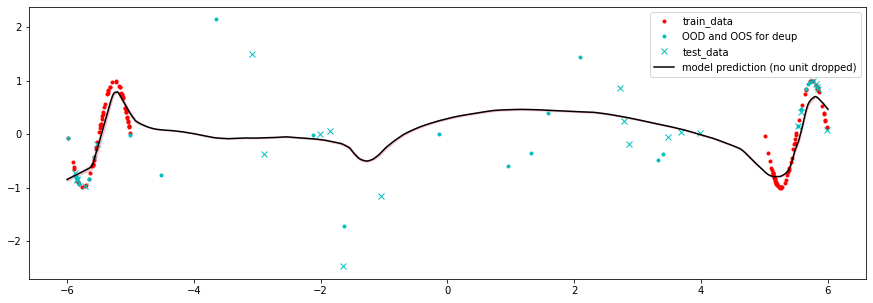

error on train data for deup (before training): 0.23074703933237672
error on train data for deup excluding train (before training): 1.4017461725812432
error on test data for deup (before training): 1.413807379714213


In [48]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [49]:
params = [y for x, y in model.named_parameters() if 'logit' in x]
print([x for x, y in model.named_parameters() if 'logit' in x])
optimizer = torch.optim.Adam(params, lr=lr)
losses = train_deup(model, optimizer, full_data, epochs=500, batch_size=32, n_samples=5, parametric_noise=False, x_input=True)

['model.dropout1.logit']


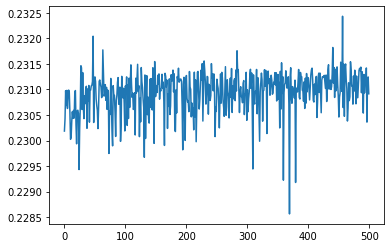

In [50]:
plt.plot(losses)

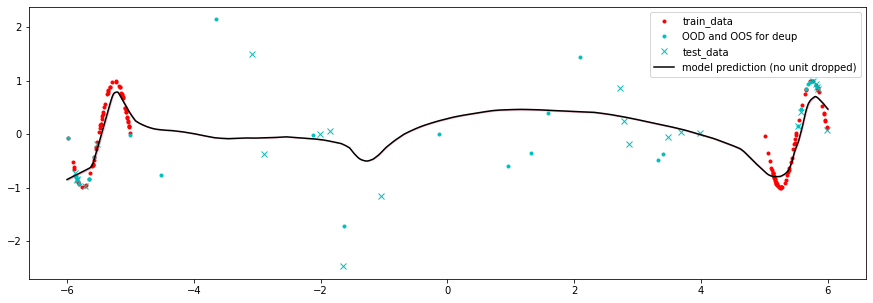

error on train data for deup (after training): 0.23026608924598
error on train data for deup excluding train (after training): 1.4006316750634533
error on test data for deup (after training): 1.414058344046665


In [51]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

### Same but with neuronwise dropout

In [ ]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(-2.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, n_hidden))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=MultiplicativeGaussian, mu=None, logsigma=logsigma,
                              noise_generator=noise_generator)
print([x[0] for x in model.named_parameters()])
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)

In [ ]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [ ]:
params = [y for x, y in model.named_parameters() if 'noise_generator' in x]
print([x for x, y in model.named_parameters() if 'noise_generator' in x])
optimizer = torch.optim.Adam(params, lr=lr)
losses = train_deup(model, optimizer, full_data, epochs=500, batch_size=32, n_samples=5, parametric_noise=True, x_input=True)

In [ ]:
plt.plot(losses)

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=True, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=True, x_input=True).item())